# 1. Description

**Source**: [MSK Redefining Cancer Treatment - Kaggle](https://www.kaggle.com/c/msk-redefining-cancer-treatment/)

### 1.1 Problem Statement:
Classify the given genetic variations/mutations based on evidence from text-based clinical literature.

### 1.2 Real-world/Business Objectives and Constraints:
- No low-latency requirement.
- Interpretability is important.
- Errors can be very costly.
- Probability of a data point belonging to each class is needed.

# 2. Machine Learning Problem Formulation

### 2.1 Data Overview
- We have two data files: one conatins the information about the genetic mutations and the other contains the clinical evidence (text) that  human experts/pathologists use to classify the genetic mutations. 
- Both these data files are have a common column called ID
- <p> 
    Data file's information:
    <ul> 
        <li>
        training_variants (ID , Gene, Variations, Class)
        </li>
        <li>
        training_text (ID, Text)
        </li>
    </ul>
</p>

### 2.2 Performance Metric
- Multi class log-loss 
- Confusion matrix 


# 3. Reading Data

In [215]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import log_loss, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import OneHotEncoder, normalize
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier

from scipy.sparse import hstack
from collections import defaultdict, Counter
import time
import re
from nltk.corpus import stopwords

#### Reading Gene and Variation Data

In [133]:
data = pd.read_csv('training_variants')
print('Number of data points : ', data.shape[0])
print('Number of features : ', data.shape[1])
print('Features : ', data.columns.values)
data.head()

Number of data points :  3321
Number of features :  4
Features :  ['ID' 'Gene' 'Variation' 'Class']


,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


<li><b>ID : </b>the id of the row used to link the mutation to the clinical evidence</li>
        <li><b>Gene : </b>the gene where this genetic mutation is located </li>
        <li><b>Variation : </b>the aminoacid change for this mutations </li>
        <li><b>Class :</b> 1-9 the class this genetic mutation has been classified on</li>

In [134]:
data_text = pd.read_csv("training_text", sep=r"\|\|", engine="python", names=["ID", "TEXT"], skiprows=1)
print('Number of data points : ', data_text.shape[0])
print('Number of features : ', data_text.shape[1])
print('Features : ', data_text.columns.values)
data_text.head()

Number of data points :  3321
Number of features :  2
Features :  ['ID' 'TEXT']


,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


# 4. Exploratory Data Analysis

#### Preprocessing of text

In [135]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\karti\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [136]:
# loading stop words from nltk library
stop_words = set(stopwords.words('english'))


def nlp_preprocessing(total_text, index, column):
    if type(total_text) is not int:
        string = ""
        # replace every special char with space
        total_text = re.sub(r'[^a-zA-Z0-9\n]', ' ', total_text)
        # replace multiple spaces with single space
        total_text = re.sub(r'\s+',' ', total_text)
        # converting all the chars into lower-case.
        total_text = total_text.lower()
        
        for word in total_text.split():
        # if the word is a not a stop word then retain that word from the data
            if not word in stop_words:
                string += word + " "
        
        data_text.loc[index, column] = string

In [137]:
start_time = time.perf_counter()
for index, row in data_text.iterrows():
    if type(row['TEXT']) is str:
        nlp_preprocessing(row['TEXT'], index, 'TEXT')
    else:
        print("there is no text description for id:", index)
print('Time took for preprocessing the text :', time.perf_counter() - start_time, "seconds")

there is no text description for id: 1109
there is no text description for id: 1277
there is no text description for id: 1407
there is no text description for id: 1639
there is no text description for id: 2755
Time took for preprocessing the text : 61.873879999970086 seconds


In [138]:
#merging both gene_variations and text_data based on ID
result = pd.merge(data, data_text, on='ID', how='left')
result.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


In [139]:
result[result.isnull().any(axis=1)]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,NaN
1277,1277,ARID5B,Truncating Mutations,1,NaN
1407,1407,FGFR3,K508M,6,NaN
1639,1639,FLT1,Amplification,6,NaN
2755,2755,BRAF,G596C,7,NaN


In [140]:
result.loc[result['TEXT'].isnull(),'TEXT'] = result['Gene'] +' '+result['Variation']

In [141]:
result[result.isnull().any(axis=1)]

,ID,Gene,Variation,Class,TEXT


In [142]:
y_true = result['Class'].values
result.Gene      = result.Gene.str.replace(r'\s+', '_')
result.Variation = result.Variation.str.replace(r'\s+', '_')

# 5. Univariate Analysis & ML

#### Preproccess before ML models & Distribution check

In [143]:
# split the data into test and train by maintaining same distribution of output varaible 'y_true' [stratify=y_true]
X_train, test_df, y_train, y_test = train_test_split(result, y_true, stratify=y_true, test_size=0.2)

# split the train data into train and cross validation by maintaining same distribution of output varaible 'y_train' [stratify=y_train]
train_df, cv_df, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

In [144]:
print('Number of data points in train data:', train_df.shape[0])
print('Number of data points in test data:', test_df.shape[0])
print('Number of data points in cross validation data:', cv_df.shape[0])

Number of data points in train data: 2124
Number of data points in test data: 665
Number of data points in cross validation data: 532


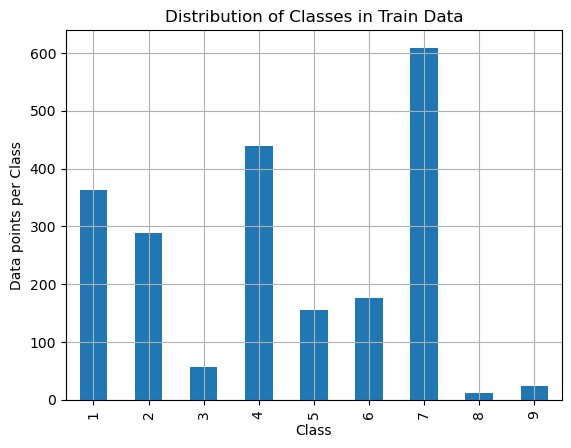

Number of data points in class 7 : 609 ( 28.672 %)
Number of data points in class 4 : 439 ( 20.669 %)
Number of data points in class 1 : 363 ( 17.09 %)
Number of data points in class 2 : 289 ( 13.606 %)
Number of data points in class 6 : 176 ( 8.286 %)
Number of data points in class 5 : 155 ( 7.298 %)
Number of data points in class 3 : 57 ( 2.684 %)
Number of data points in class 9 : 24 ( 1.13 %)
Number of data points in class 8 : 12 ( 0.565 %)
--------------------------------------------------------------------------------


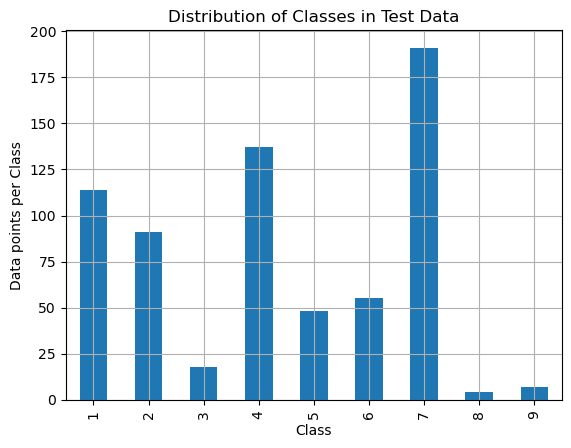

Number of data points in class 7 : 191 ( 28.722 %)
Number of data points in class 4 : 137 ( 20.602 %)
Number of data points in class 1 : 114 ( 17.143 %)
Number of data points in class 2 : 91 ( 13.684 %)
Number of data points in class 6 : 55 ( 8.271 %)
Number of data points in class 5 : 48 ( 7.218 %)
Number of data points in class 3 : 18 ( 2.707 %)
Number of data points in class 9 : 7 ( 1.053 %)
Number of data points in class 8 : 4 ( 0.602 %)
--------------------------------------------------------------------------------


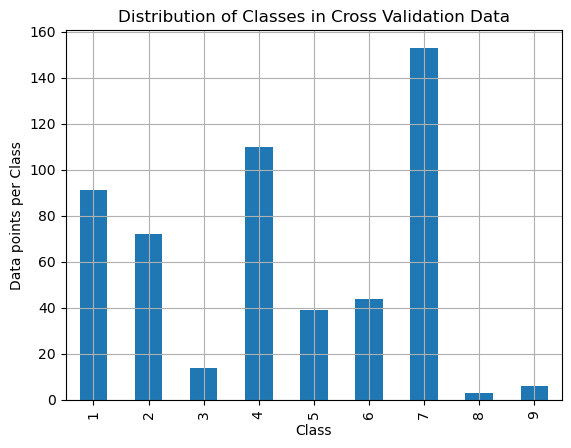

Number of data points in class 7 : 153 ( 28.759 %)
Number of data points in class 4 : 110 ( 20.677 %)
Number of data points in class 1 : 91 ( 17.105 %)
Number of data points in class 2 : 72 ( 13.534 %)
Number of data points in class 6 : 44 ( 8.271 %)
Number of data points in class 5 : 39 ( 7.331 %)
Number of data points in class 3 : 14 ( 2.632 %)
Number of data points in class 9 : 6 ( 1.128 %)
Number of data points in class 8 : 3 ( 0.564 %)


In [145]:
# This returns a dict, where the keys are class labels and values are the number of data points in that class
train_class_distribution = train_df['Class'].value_counts().sort_index()
test_class_distribution = test_df['Class'].value_counts().sort_index()
cv_class_distribution = cv_df['Class'].value_counts().sort_index()

# Plotting the distribution of classes in the training data
train_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of Classes in Train Data')
plt.grid()
plt.show()

# Sorting the class distribution by the number of data points in decreasing order
sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    # Print the class index, the number of data points in that class, and its percentage
    print('Number of data points in class', i + 1, ':', train_class_distribution.values[i], 
          '(', np.round((train_class_distribution.values[i] / train_df.shape[0] * 100), 3), '%)')

print('-' * 80)

# Plotting the distribution of classes in the test data
test_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of Classes in Test Data')
plt.grid()
plt.show()

# Sorting the test class distribution in decreasing order
sorted_yi = np.argsort(-test_class_distribution.values)
for i in sorted_yi:
    # Print the class index, the number of data points in that class, and its percentage
    print('Number of data points in class', i + 1, ':', test_class_distribution.values[i], 
          '(', np.round((test_class_distribution.values[i] / test_df.shape[0] * 100), 3), '%)')

print('-' * 80)

# Plotting the distribution of classes in the cross-validation data
cv_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of Classes in Cross Validation Data')
plt.grid()
plt.show()

# Sorting the cross-validation class distribution in decreasing order
sorted_yi = np.argsort(-cv_class_distribution.values)
for i in sorted_yi:
    # Print the class index, the number of data points in that class, and its percentage
    print('Number of data points in class', i + 1, ':', cv_class_distribution.values[i], 
          '(', np.round((cv_class_distribution.values[i] / cv_df.shape[0] * 100), 3), '%)')


#### Prediction using a 'Random' Model

In [146]:
# Function to plot confusion matrices
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C is a confusion matrix, each cell (i, j) represents the number of points of class i that are predicted as class j
    
    # Recall matrix (row normalization)
    # A = (C.T / C.sum(axis=1)).T
    # Each element of the confusion matrix is divided by the sum of elements in that row (axis=1)
    # Resulting matrix A represents the recall matrix where each row sums to 1
    
    # Precision matrix (column normalization)
    # B = C / C.sum(axis=0)
    # Each element of the confusion matrix is divided by the sum of elements in that column (axis=0)
    # Resulting matrix B represents the precision matrix where each column sums to 1


    # Recall matrix (row normalization)
    A = np.zeros_like(C, dtype=float)  # Initialize recall matrix
    for i in range(C.shape[0]):
        if C.sum(axis=1)[i] > 0:  # Check if the sum is not zero
            A[i] = C[i] / C.sum(axis=1)[i]  # Row normalization
    
    # Precision matrix (column normalization)
    B = np.zeros_like(C, dtype=float)  # Initialize precision matrix
    for j in range(C.shape[1]):
        if C.sum(axis=0)[j] > 0:  # Check if the sum is not zero
            B[:, j] = C[:, j] / C.sum(axis=0)[j]  # Column normalization

    
    labels = [1,2,3,4,5,6,7,8,9]

    # Plotting the original confusion matrix
    print("-" * 20, "Confusion matrix", "-" * 20)
    plt.figure(figsize=(8, 4))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt="g", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion Matrix")
    plt.show()

    # Plotting the precision matrix (column sums = 1)
    print("-" * 20, "Precision matrix (Column Sum=1)", "-" * 20)
    plt.figure(figsize=(8, 4))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision Matrix")
    plt.show()

    # Plotting the recall matrix (row sums = 1)
    print("-" * 20, "Recall matrix (Row sum=1)", "-" * 20)
    plt.figure(figsize=(8, 4))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall Matrix")
    plt.show()

Log loss on Cross Validation Data using Random Model 2.508344407079538
Log loss on Test Data using Random Model 2.4940110415000913
-------------------- Confusion matrix --------------------


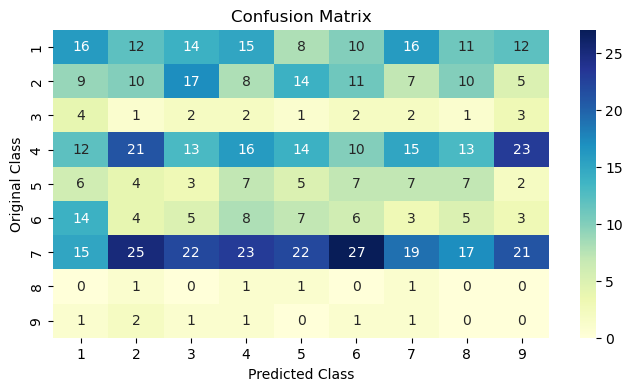

-------------------- Precision matrix (Column Sum=1) --------------------


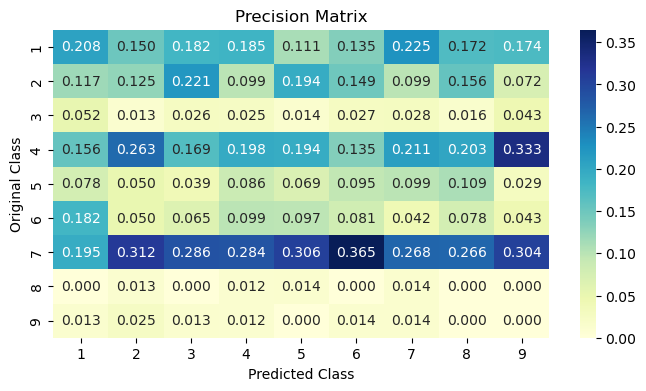

-------------------- Recall matrix (Row sum=1) --------------------


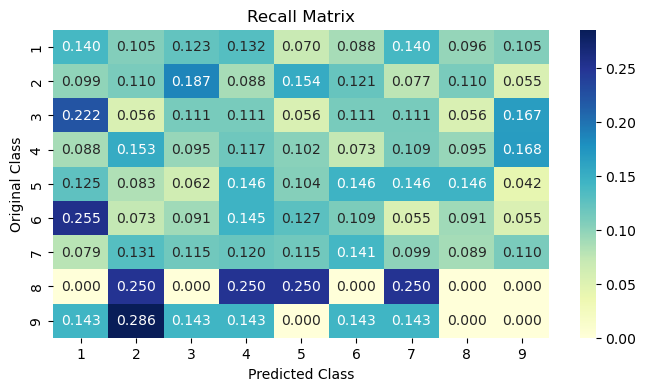

In [147]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
test_data_len = test_df.shape[0]
cv_data_len = cv_df.shape[0]

# we create a output array that has exactly same size as the CV data
cv_predicted_y = np.zeros((cv_data_len,9))
for i in range(cv_data_len):
    rand_probs = np.random.rand(9)
    cv_predicted_y[i] = rand_probs / rand_probs.sum()
print("Log loss on Cross Validation Data using Random Model",log_loss(y_cv,cv_predicted_y))


# Test-Set error.
#we create a output array that has exactly same as the test data
test_predicted_y = np.zeros((test_data_len,9))
for i in range(test_data_len):
    rand_probs = np.random.rand(9)
    test_predicted_y[i] = rand_probs / rand_probs.sum()
print("Log loss on Test Data using Random Model",log_loss(y_test,test_predicted_y))

predicted_y =np.argmax(test_predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y+1)

####  Code for response coding with Laplace smoothing.

In [148]:
# alpha : used for laplace smoothing
# feature: ['gene', 'variation']
# df: ['train_df', 'test_df', 'cv_df']

# when we caculate the probability of a feature belongs to any particular class, we apply laplace smoothing
# (numerator + 10\*alpha) / (denominator + 90\*alpha)

# algorithm
# --------------------------
# Consider all unique values and the number of occurances of given feature in train data dataframe
# build a vector (1*9) , the first element = (number of times it occured in class1 + 10*alpha / number of time it occurred in total data+90*alpha)
# gv_dict is like a look up table, for every gene it store a (1*9) representation of it
# for a value of feature in df:
# if it is in train data:
# we add the vector that was stored in 'gv_dict' look up table to 'gv_fea'
# if it is not there is train:
# we add [1/9, 1/9, 1/9, 1/9,1/9, 1/9, 1/9, 1/9, 1/9] to 'gv_fea'
# return 'gv_fea'
# --------------------------

# get_gv_fea_dict: Get Gene varaition Feature Dict
def get_gv_fea_dict(alpha, feature, df):
    # value_count: it contains a dict like
    # print(train_df['Gene'].value_counts())
    # output:
    #        {BRCA1      174
    #         TP53       106
    #         EGFR        86
    #         BRCA2       75
    #         PTEN        69
    #         KIT         61
    #         BRAF        60
    #         ERBB2       47
    #         PDGFRA      46
    #         ...}
    # print(train_df['Variation'].value_counts())
    # output:
    # {
    # Truncating_Mutations                     63
    # Deletion                                 43
    # Amplification                            43
    # Fusions                                  22
    # Overexpression                            3
    # E17K                                      3
    # Q61L                                      3
    # S222D                                     2
    # P130S                                     2
    # ...
    # }
    value_count = train_df[feature].value_counts()
    
    # gv_dict : Gene Variation Dict, which contains the probability array for each gene/variation
    gv_dict = dict()
    
    # denominator will contain the number of time that particular feature occured in whole data
    for i, denominator in value_count.items():
        # vec will contain (p(yi==1/Gi) probability of gene/variation belongs to perticular class
        # vec is 9 diamensional vector
        vec = []
        for k in range(1,10):
            # print(train_df.loc[(train_df['Class']==1) & (train_df['Gene']=='BRCA1')])
            #         ID   Gene             Variation  Class  
            # 2470  2470  BRCA1                S1715C      1   
            # 2486  2486  BRCA1                S1841R      1   
            # 2614  2614  BRCA1                   M1R      1   
            # 2432  2432  BRCA1                L1657P      1   
            # 2567  2567  BRCA1                T1685A      1   
            # 2583  2583  BRCA1                E1660G      1   
            # 2634  2634  BRCA1                W1718L      1   
            # cls_cnt.shape[0] will return the number of rows

            cls_cnt = train_df.loc[(train_df['Class']==k) & (train_df[feature]==i)]
            
            # cls_cnt.shape[0](numerator) will contain the number of time that particular feature occured in whole data
            vec.append((cls_cnt.shape[0] + alpha*10)/ (denominator + 90*alpha))

        # we are adding the gene/variation to the dict as key and vec as value
        gv_dict[i]=vec
    return gv_dict

# Get Gene variation feature
def get_gv_feature(alpha, feature, df):
    # print(gv_dict)
    #     {'BRCA1': [0.20075757575757575, 0.03787878787878788, 0.068181818181818177, 0.13636363636363635, 0.25, 0.19318181818181818, 0.03787878787878788, 0.03787878787878788, 0.03787878787878788], 
    #      'TP53': [0.32142857142857145, 0.061224489795918366, 0.061224489795918366, 0.27040816326530615, 0.061224489795918366, 0.066326530612244902, 0.051020408163265307, 0.051020408163265307, 0.056122448979591837], 
    #      'EGFR': [0.056818181818181816, 0.21590909090909091, 0.0625, 0.068181818181818177, 0.068181818181818177, 0.0625, 0.34659090909090912, 0.0625, 0.056818181818181816], 
    #      'BRCA2': [0.13333333333333333, 0.060606060606060608, 0.060606060606060608, 0.078787878787878782, 0.1393939393939394, 0.34545454545454546, 0.060606060606060608, 0.060606060606060608, 0.060606060606060608], 
    #      'PTEN': [0.069182389937106917, 0.062893081761006289, 0.069182389937106917, 0.46540880503144655, 0.075471698113207544, 0.062893081761006289, 0.069182389937106917, 0.062893081761006289, 0.062893081761006289], 
    #      'KIT': [0.066225165562913912, 0.25165562913907286, 0.072847682119205295, 0.072847682119205295, 0.066225165562913912, 0.066225165562913912, 0.27152317880794702, 0.066225165562913912, 0.066225165562913912], 
    #      'BRAF': [0.066666666666666666, 0.17999999999999999, 0.073333333333333334, 0.073333333333333334, 0.093333333333333338, 0.080000000000000002, 0.29999999999999999, 0.066666666666666666, 0.066666666666666666],
    #      ...
    #     }
    gv_dict = get_gv_fea_dict(alpha, feature, df)
    # value_count is similar in get_gv_fea_dict
    value_count = train_df[feature].value_counts()
    
    # gv_fea: Gene_variation feature, it will contain the feature for each feature value in the data
    gv_fea = []
    # for every feature values in the given data frame we will check if it is there in the train data then we will add the feature to gv_fea
    # if not we will add [1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9] to gv_fea
    for index, row in df.iterrows():
        if row[feature] in dict(value_count).keys():
            gv_fea.append(gv_dict[row[feature]])
        else:
            gv_fea.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9])
#             gv_fea.append([-1,-1,-1,-1,-1,-1,-1,-1,-1])
    return gv_fea

####  Univariate Analysis on Gene Feature

In [149]:
unique_genes = train_df['Gene'].value_counts()
print('Number of Unique Genes :', unique_genes.shape[0])
# the top 10 genes that occured most
print(unique_genes.head(10))

Number of Unique Genes : 240
Gene
BRCA1     163
TP53      100
EGFR       93
PTEN       89
BRCA2      79
BRAF       62
KIT        56
ALK        43
PIK3CA     40
ERBB2      40
Name: count, dtype: int64


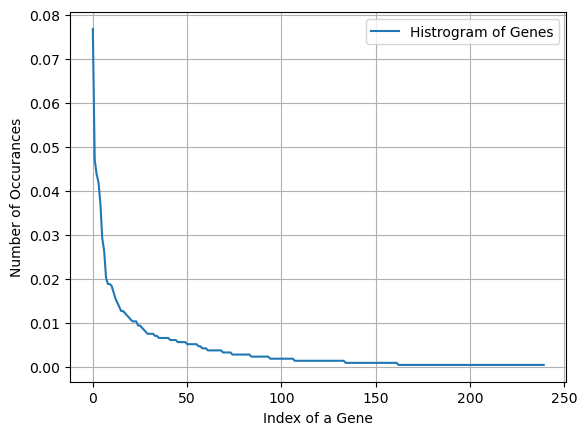

In [150]:
s = sum(unique_genes.values);
h = unique_genes.values/s;
plt.plot(h, label="Histrogram of Genes")
plt.xlabel('Index of a Gene')
plt.ylabel('Number of Occurances')
plt.legend()
plt.grid()
plt.show()

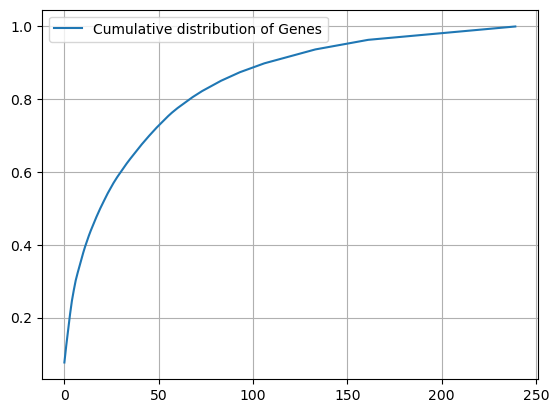

In [151]:
c = np.cumsum(h)
plt.plot(c,label='Cumulative distribution of Genes')
plt.grid()
plt.legend()
plt.show()

<p style="font-size:16px;"><b></b>there are two ways we can featurize this Gene variable
<ol><li>One hot Encoding</li><li>Response coding</li></ol></p>
<p> We will choose the appropriate featurization based on the ML model we use.  For this problem of multi-class classification with categorical features, one-hot encoding is better for Logistic regression while response coding is better for Random Forests. </p>

In [152]:
# Response-Coding of the Gene feature

# alpha is used for laplace smoothing
alpha = 1
# train gene feature
train_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", train_df))
# test gene feature
test_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", test_df))
# cross validation gene feature
cv_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", cv_df))

In [153]:
print("train_gene_feature_responseCoding is converted feature using respone coding method. The shape of gene feature:", train_gene_feature_responseCoding.shape)

train_gene_feature_responseCoding is converted feature using respone coding method. The shape of gene feature: (2124, 9)


In [154]:
# One-Hot encoding of Gene feature.

gene_vectorizer = TfidfVectorizer()
train_gene_feature_onehotCoding = gene_vectorizer.fit_transform(train_df['Gene'])
test_gene_feature_onehotCoding = gene_vectorizer.transform(test_df['Gene'])
cv_gene_feature_onehotCoding = gene_vectorizer.transform(cv_df['Gene'])

In [155]:
print("train_gene_feature_onehotCoding is converted feature using one-hot encoding method. The shape of gene feature:", train_gene_feature_onehotCoding.shape)

train_gene_feature_onehotCoding is converted feature using one-hot encoding method. The shape of gene feature: (2124, 239)


There are many ways to estimate how good a feature is, in predicting y_i. One of the good methods is to build a proper ML model using just this feature. In this case, we will build a logistic regression model using only Gene feature (one hot encoded) to predict y_i.

For alpha = 1e-05, the log loss is: 1.223998756034847
For alpha = 0.0001, the log loss is: 1.2081025428674883
For alpha = 0.001, the log loss is: 1.2409706941701695
For alpha = 0.01, the log loss is: 1.351872426839506
For alpha = 0.1, the log loss is: 1.4405206622399571
For alpha = 1, the log loss is: 1.4790033927249624


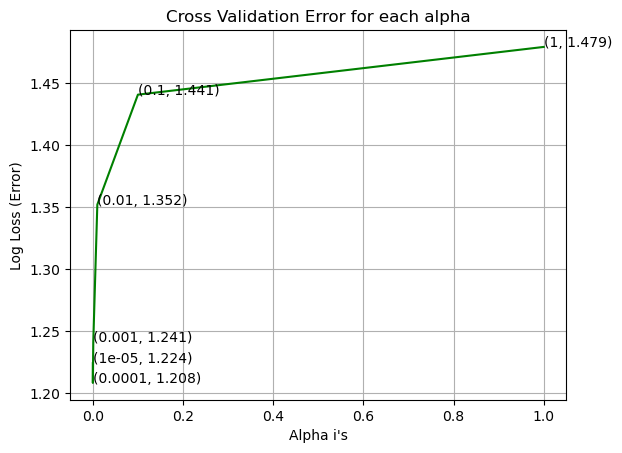

For best alpha = 0.0001, the train log loss is: 0.9780116946833639
For best alpha = 0.0001, the cross-validation log loss is: 1.2081025428674883
For best alpha = 0.0001, the test log loss is: 1.2021672959074303


In [156]:
alpha = [10 ** x for x in range(-5, 1)] # hyperparam for SGD classifier.

cv_log_error_array=[]

for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log_loss', random_state=42, max_iter=1000, tol=1e-3)
    clf.fit(train_gene_feature_onehotCoding, y_train)

    # Calibrate the classifier with Sigmoid for probability prediction
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_gene_feature_onehotCoding, y_train)
    
    # Predict probabilities on cross-validation set
    predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)

    # Calculate log loss and append to list
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_))
    
    # Print log loss for the current alpha value
    print(f'For alpha = {i}, the log loss is: {log_loss(y_cv, predict_y, labels=clf.classes_)}')


# Plotting the cross-validation error for each alpha value
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')

# Annotating the points on the plot with alpha values and corresponding errors
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
    
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Log Loss (Error)")
plt.show()


# Find the best alpha (with the smallest log loss)
best_alpha_index = np.argmin(cv_log_error_array)
best_alpha = alpha[best_alpha_index]

# Train classifier with the best alpha
clf = SGDClassifier(alpha=best_alpha, penalty='l2', loss='log_loss', random_state=42, max_iter=1000, tol=1e-3)
clf.fit(train_gene_feature_onehotCoding, y_train)

# Calibrate the classifier with Sigmoid
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_gene_feature_onehotCoding, y_train)

# Calculate log loss for train, CV, and test sets
train_log_loss = log_loss(y_train, sig_clf.predict_proba(train_gene_feature_onehotCoding), labels=clf.classes_)
cv_log_loss = log_loss(y_cv, sig_clf.predict_proba(cv_gene_feature_onehotCoding), labels=clf.classes_)
test_log_loss = log_loss(y_test, sig_clf.predict_proba(test_gene_feature_onehotCoding), labels=clf.classes_)

# Print the log loss for the best alpha
print(f'For best alpha = {best_alpha}, the train log loss is: {train_log_loss}')
print(f'For best alpha = {best_alpha}, the cross-validation log loss is: {cv_log_loss}')
print(f'For best alpha = {best_alpha}, the test log loss is: {test_log_loss}')

the Gene feature stable across all the data sets (Test, Train, Cross validation)

In [157]:
# Calculate the unique genes in the train dataset
unique_genes = train_df['Gene'].unique()

# Test dataset coverage: Check how many test samples have a 'Gene' that exists in the training set
test_coverage = test_df[test_df['Gene'].isin(unique_genes)].shape[0]

# Cross-validation dataset coverage: Check how many CV samples have a 'Gene' that exists in the training set
cv_coverage = cv_df[cv_df['Gene'].isin(unique_genes)].shape[0]

# Output the coverage for both test and CV datasets
print(f"Q. How many data points in Test and CV datasets are covered by the {len(unique_genes)} genes in the train dataset?")
print(f'1. In test data: {test_coverage} out of {test_df.shape[0]} : {(test_coverage/test_df.shape[0]) * 100:.2f}%')
print(f'2. In cross-validation data: {cv_coverage} out of {cv_df.shape[0]} : {(cv_coverage/cv_df.shape[0]) * 100:.2f}%')

Q. How many data points in Test and CV datasets are covered by the 240 genes in the train dataset?
1. In test data: 648 out of 665 : 97.44%
2. In cross-validation data: 518 out of 532 : 97.37%


#### Univariate Analysis on Variation Feature

In [158]:
unique_variations = train_df['Variation'].value_counts()
print('Number of Unique Variations :', unique_variations.shape[0])

# the top 10 variations that occured most
print(unique_variations.head(10))

Number of Unique Variations : 1928
Variation
Truncating Mutations    61
Amplification           46
Deletion                45
Fusions                 19
Overexpression           5
Q61R                     3
E17K                     3
R841K                    2
P130S                    2
Y42C                     2
Name: count, dtype: int64


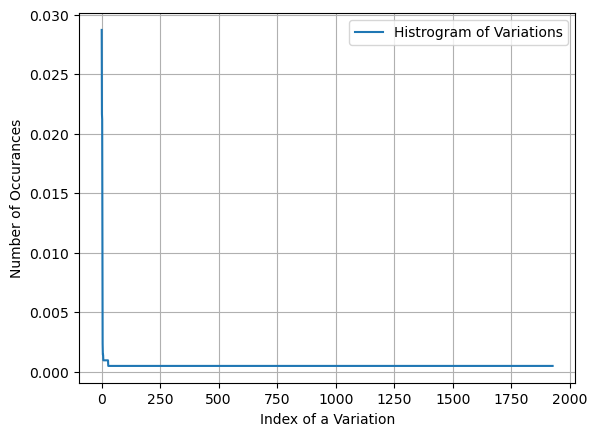

In [159]:
s = sum(unique_variations.values);
h = unique_variations.values/s;
plt.plot(h, label="Histrogram of Variations")
plt.xlabel('Index of a Variation')
plt.ylabel('Number of Occurances')
plt.legend()
plt.grid()
plt.show()

[0.0287194  0.05037665 0.07156309 ... 0.99905838 0.99952919 1.        ]


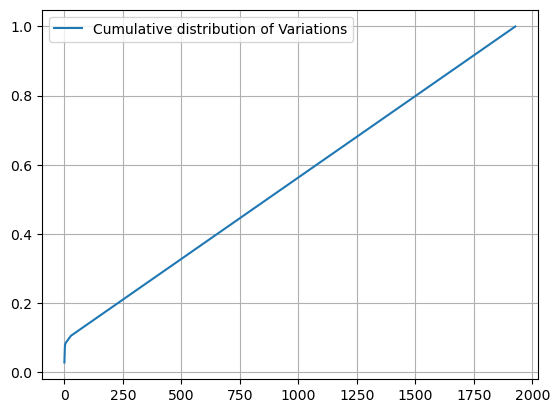

In [160]:
c = np.cumsum(h)
print(c)
plt.plot(c,label='Cumulative distribution of Variations')
plt.grid()
plt.legend()
plt.show()

In [161]:
# Response-Coding of the Variation feature

# alpha is used for laplace smoothing
alpha = 1

# train Variation feature
train_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", train_df))
# test Variation feature
test_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", test_df))
# cross validation Variation feature
cv_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", cv_df))

In [162]:
print("train_variation_feature_responseCoding is a converted feature using the response coding method. The shape of Variation feature:", train_variation_feature_responseCoding.shape)

train_variation_feature_responseCoding is a converted feature using the response coding method. The shape of Variation feature: (2124, 9)


In [163]:
# one-hot encoding of variation feature.

variation_vectorizer = TfidfVectorizer()
train_variation_feature_onehotCoding = variation_vectorizer.fit_transform(train_df['Variation'])
test_variation_feature_onehotCoding = variation_vectorizer.transform(test_df['Variation'])
cv_variation_feature_onehotCoding = variation_vectorizer.transform(cv_df['Variation'])

In [164]:
print("train_variation_feature_onehotEncoded is converted feature using the one-hot encoding method. The shape of Variation feature:", train_variation_feature_onehotCoding.shape)

train_variation_feature_onehotEncoded is converted feature using the one-hot encoding method. The shape of Variation feature: (2124, 1967)


For values of alpha =  1e-05 The log loss is: 1.6742046601735183
For values of alpha =  0.0001 The log loss is: 1.6636132023612207
For values of alpha =  0.001 The log loss is: 1.6702714388936653
For values of alpha =  0.01 The log loss is: 1.676147719619769
For values of alpha =  0.1 The log loss is: 1.6920039564391902
For values of alpha =  1 The log loss is: 1.69283424069679


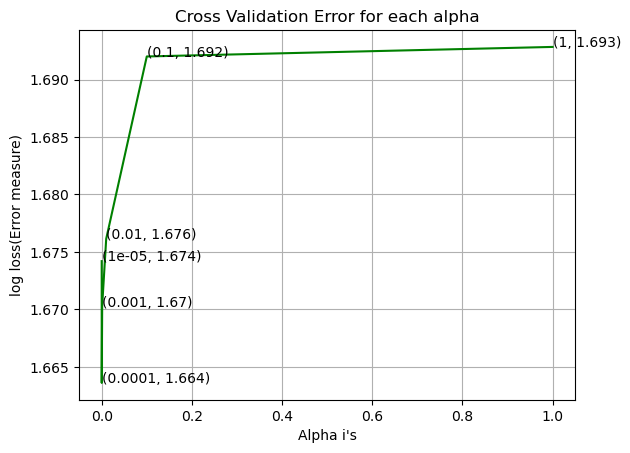

For best alpha = 0.0001, the train log loss is: 0.6802084689577602
For best alpha = 0.0001, the cross-validation log loss is: 1.6636132023612207
For best alpha = 0.0001, the test log loss is: 1.7057690927344227


In [165]:
alpha = [10 ** x for x in range(-5, 1)]


cv_log_error_array=[]

for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log_loss', random_state=42)
    clf.fit(train_variation_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_variation_feature_onehotCoding, y_train)
    
    predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
    
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array, c='g')

for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
    
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("log loss(Error measure)")
plt.show()


best_alpha_index = np.argmin(cv_log_error_array)
best_alpha = alpha[best_alpha_index]

clf = SGDClassifier(alpha=best_alpha, penalty='l2', loss='log_loss', random_state=42)
clf.fit(train_variation_feature_onehotCoding, y_train)

sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_variation_feature_onehotCoding, y_train)

train_log_loss = log_loss(y_train, sig_clf.predict_proba(train_variation_feature_onehotCoding), labels=clf.classes_)
cv_log_loss = log_loss(y_cv, sig_clf.predict_proba(cv_variation_feature_onehotCoding), labels=clf.classes_)
test_log_loss = log_loss(y_test, sig_clf.predict_proba(test_variation_feature_onehotCoding), labels=clf.classes_)

print(f'For best alpha = {best_alpha}, the train log loss is: {train_log_loss}')
print(f'For best alpha = {best_alpha}, the cross-validation log loss is: {cv_log_loss}')
print(f'For best alpha = {best_alpha}, the test log loss is: {test_log_loss}')

Its not that stable but lets check once again below analysis.

In [166]:
# Calculate the unique variations in the train dataset
unique_variations = train_df['Variation'].unique()

# Test dataset coverage: Check how many test samples have a 'Variation' that exists in the training set
test_coverage = test_df[test_df['Variation'].isin(unique_variations)].shape[0]

# Cross-validation dataset coverage: Check how many CV samples have a 'Variation' that exists in the training set
cv_coverage = cv_df[cv_df['Variation'].isin(unique_variations)].shape[0]

# Output the coverage for both test and CV datasets
print(f"Q. How many data points are covered by total {len(unique_variations)} variations in test and cross-validation datasets?")
print(f'1. In test data: {test_coverage} out of {test_df.shape[0]} : {(test_coverage/test_df.shape[0]) * 100:.2f}%')
print(f'2. In cross-validation data: {cv_coverage} out of {cv_df.shape[0]} : {(cv_coverage/cv_df.shape[0]) * 100:.2f}%')

Q. How many data points are covered by total 1928 variations in test and cross-validation datasets?
1. In test data: 64 out of 665 : 9.62%
2. In cross-validation data: 61 out of 532 : 11.47%


#### Univariate Analysis on Text Feature

In [167]:
# cls_text is a data frame
# for every row in data fram consider the 'TEXT'
# split the words by space
# make a dict with those words
# increment its count whenever we see that word

def extract_dictionary_paddle(cls_text):
    dictionary = defaultdict(int)
    for index, row in cls_text.iterrows():
        for word in row['TEXT'].split():
            dictionary[word] +=1
    return dictionary

In [168]:
import math

def get_text_responsecoding(df):
    text_feature_responseCoding = np.zeros((df.shape[0],9))
    
    for i in range(0,9):
        row_index = 0
        
        for index, row in df.iterrows():
            sum_prob = 0
            
            for word in row['TEXT'].split():
                sum_prob += math.log(((dict_list[i].get(word,0)+10 )/(total_dict.get(word,0)+90)))
                
            text_feature_responseCoding[row_index][i] = math.exp(sum_prob/len(row['TEXT'].split()))
            row_index += 1
            
    return text_feature_responseCoding

In [169]:
dict_list = []
# dict_list =[] contains 9 dictoinaries each corresponds to a class
for i in range(1,10):
    cls_text = train_df[train_df['Class']==i]
    # build a word dict based on the words in that class
    dict_list.append(extract_dictionary_paddle(cls_text))
    # append it to dict_list

# dict_list[i] is build on i'th  class text data
# total_dict is buid on whole training text data
total_dict = extract_dictionary_paddle(train_df)

In [170]:
#response coding of text features
train_text_feature_responseCoding  = get_text_responsecoding(train_df)
test_text_feature_responseCoding  = get_text_responsecoding(test_df)
cv_text_feature_responseCoding  = get_text_responsecoding(cv_df)

In [171]:
# we convert each row values such that they sum to 1  
train_text_feature_responseCoding = (train_text_feature_responseCoding.T/train_text_feature_responseCoding.sum(axis=1)).T
test_text_feature_responseCoding = (test_text_feature_responseCoding.T/test_text_feature_responseCoding.sum(axis=1)).T
cv_text_feature_responseCoding = (cv_text_feature_responseCoding.T/cv_text_feature_responseCoding.sum(axis=1)).T

In [172]:
# building a TfidfVectorizer with all the words that occured minimum 3 times in train data
text_vectorizer = TfidfVectorizer(min_df=3)
train_text_feature_onehotCoding = text_vectorizer.fit_transform(train_df['TEXT'])

# getting all the feature names (words)
train_text_features= text_vectorizer.get_feature_names_out()

# train_text_feature_onehotCoding.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
train_text_fea_counts = train_text_feature_onehotCoding.sum(axis=0).A1

# zip(list(text_features),text_fea_counts) will zip a word with its number of times it occured
text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))

print("Total number of unique words in train data :", len(train_text_features))

Total number of unique words in train data : 54480


In [173]:
# normalize every feature
train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
test_text_feature_onehotCoding = text_vectorizer.transform(test_df['TEXT'])
# normalize every feature
test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
cv_text_feature_onehotCoding = text_vectorizer.transform(cv_df['TEXT'])
# =normalize every feature
cv_text_feature_onehotCoding = normalize(cv_text_feature_onehotCoding, axis=0)

In [174]:
sorted_text_fea_dict = dict(sorted(text_fea_dict.items(), key=lambda x: x[1] , reverse=True))
sorted_text_occur = np.array(list(sorted_text_fea_dict.values()))

In [175]:
# Number of words for a given frequency.
# print(Counter(sorted_text_occur))

For values of alpha =  1e-05 The log loss is: 1.2599282175871278
For values of alpha =  0.0001 The log loss is: 1.204392206907946
For values of alpha =  0.001 The log loss is: 1.2300526942788792
For values of alpha =  0.01 The log loss is: 1.33911465161377
For values of alpha =  0.1 The log loss is: 1.3605637844710392
For values of alpha =  1 The log loss is: 1.519366506933484


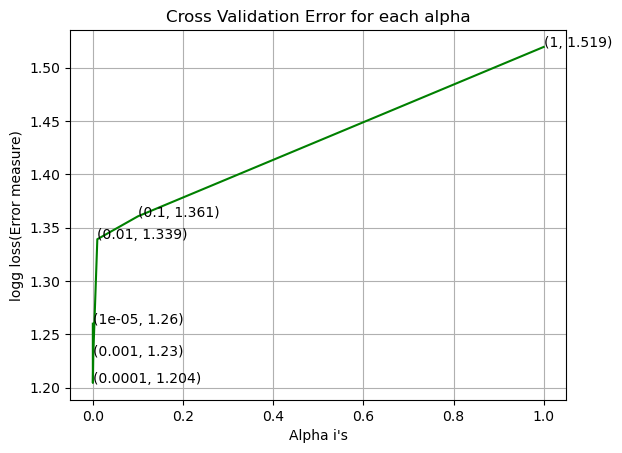

For best alpha = 0.0001, the train log loss is: 0.5858334732079367
For best alpha = 0.0001, the cross-validation log loss is: 1.204392206907946
For best alpha = 0.0001, the test log loss is: 1.136956525857239


In [176]:
# Train a Logistic regression+Calibration model using text features whicha re on-hot encoded
alpha = [10 ** x for x in range(-5, 1)]

cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log_loss', random_state=42)
    clf.fit(train_text_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_text_feature_onehotCoding, y_train)
    
    predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
    
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("logg loss(Error measure)")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
best_alpha=alpha[best_alpha]

clf = SGDClassifier(alpha=best_alpha, penalty='l2', loss='log_loss', random_state=42)
clf.fit(train_text_feature_onehotCoding, y_train)

sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_text_feature_onehotCoding, y_train)

train_log_loss = log_loss(y_train, sig_clf.predict_proba(train_text_feature_onehotCoding), labels=clf.classes_)
cv_log_loss = log_loss(y_cv, sig_clf.predict_proba(cv_text_feature_onehotCoding), labels=clf.classes_)
test_log_loss = log_loss(y_test, sig_clf.predict_proba(test_text_feature_onehotCoding), labels=clf.classes_)

print(f'For best alpha = {best_alpha}, the train log loss is: {train_log_loss}')
print(f'For best alpha = {best_alpha}, the cross-validation log loss is: {cv_log_loss}')
print(f'For best alpha = {best_alpha}, the test log loss is: {test_log_loss}')

In [177]:
def get_intersec_text(df):
    df_text_vec = CountVectorizer(min_df=3)
    df_text_fea = df_text_vec.fit_transform(df['TEXT'])
    df_text_features = df_text_vec.get_feature_names_out()

    df_text_fea_counts = df_text_fea.sum(axis=0).A1
    df_text_fea_dict = dict(zip(list(df_text_features),df_text_fea_counts))
    len1 = len(set(df_text_features))
    len2 = len(set(train_text_features) & set(df_text_features))
    return len1,len2

len1,len2 = get_intersec_text(test_df)
print(np.round((len2/len1)*100, 3), "% of word of test data appeared in train data")

len1,len2 = get_intersec_text(cv_df)
print(np.round((len2/len1)*100, 3), "% of word of Cross Validation appeared in train data")

97.766 % of word of test data appeared in train data
98.987 % of word of Cross Validation appeared in train data


# 6. Machine Learning Models

#### Misc. functionns for ML models

In [178]:
def predict_and_plot_confusion_matrix(train_x, train_y, test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x)

    # for calculating log_loss we willl provide the array of probabilities belongs to each class
    print("Log loss :",log_loss(test_y, sig_clf.predict_proba(test_x)))
    
    # calculating the number of data points that are misclassified
    print("Number of mis-classified points :", np.count_nonzero((pred_y- test_y))/test_y.shape[0])
    plot_confusion_matrix(test_y, pred_y)

Stacking the three types of features

In [179]:
# merging gene, variance and text features
# building train, test and cross validation data sets

train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

train_x_onehotCoding = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding)).tocsr()
train_y = np.array(list(train_df['Class']))

test_x_onehotCoding = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding)).tocsr()
test_y = np.array(list(test_df['Class']))

cv_x_onehotCoding = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding)).tocsr()
cv_y = np.array(list(cv_df['Class']))

In [180]:
print("One hot encoding features :")
print("(number of data points , number of features) in train data = ", train_x_onehotCoding.shape)
print("(number of data points , number of features) in test data = ", test_x_onehotCoding.shape)
print("(number of data points , number of features) in cross validation data =", cv_x_onehotCoding.shape)

One hot encoding features :
(number of data points , number of features) in train data =  (2124, 56686)
(number of data points , number of features) in test data =  (665, 56686)
(number of data points , number of features) in cross validation data = (532, 56686)


In [181]:
train_gene_var_responseCoding = np.hstack((train_gene_feature_responseCoding,train_variation_feature_responseCoding))
test_gene_var_responseCoding = np.hstack((test_gene_feature_responseCoding,test_variation_feature_responseCoding))
cv_gene_var_responseCoding = np.hstack((cv_gene_feature_responseCoding,cv_variation_feature_responseCoding))

train_x_responseCoding = np.hstack((train_gene_var_responseCoding, train_text_feature_responseCoding))
test_x_responseCoding = np.hstack((test_gene_var_responseCoding, test_text_feature_responseCoding))
cv_x_responseCoding = np.hstack((cv_gene_var_responseCoding, cv_text_feature_responseCoding))

In [182]:
print(" Response encoding features :")
print("(number of data points , number of features) in train data = ", train_x_responseCoding.shape)
print("(number of data points , number of features) in test data = ", test_x_responseCoding.shape)
print("(number of data points , number of features) in cross validation data =", cv_x_responseCoding.shape)

 Response encoding features :
(number of data points , number of features) in train data =  (2124, 27)
(number of data points , number of features) in test data =  (665, 27)
(number of data points , number of features) in cross validation data = (532, 27)


### 6.1 Naive Bayes

#### Hyper parameter tuning

For alpha = 1e-05 , Log Loss : 1.308521690223177
For alpha = 0.0001 , Log Loss : 1.3101668454720035
For alpha = 0.001 , Log Loss : 1.3186907682271103
For alpha = 0.1 , Log Loss : 1.323020178119137
For alpha = 1 , Log Loss : 1.3035358001822228
For alpha = 10 , Log Loss : 1.3983216692234557
For alpha = 100 , Log Loss : 1.329055665921935
For alpha = 1000 , Log Loss : 1.2558253329796907


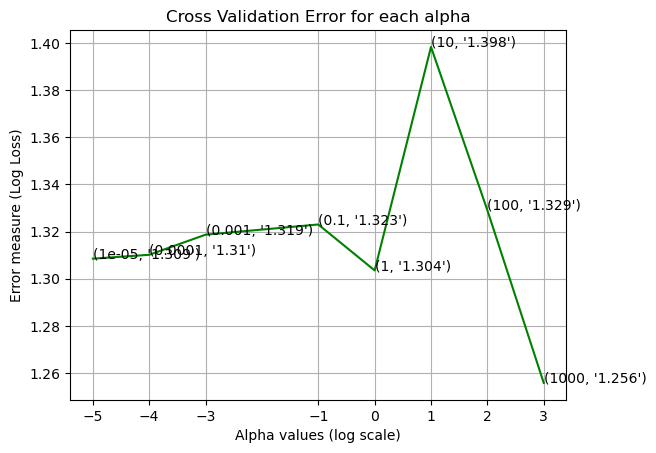

Best alpha: 1000
Train Log Loss: 0.9062936691301686
CV Log Loss: 1.2558253329796907
Test Log Loss: 1.2050955238689676


In [183]:
alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100, 1000]
cv_log_error_array = []

for i in alpha:  
    # Initialize and fit MultinomialNB
    clf = MultinomialNB(alpha=i)
    clf.fit(train_x_onehotCoding, train_y)
    
    # Apply calibration using CalibratedClassifierCV
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    
    # Get probabilities for cross-validation data
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    
    # Calculate and store log loss for cross-validation data
    log_error = log_loss(cv_y, sig_clf_probs, labels=clf.classes_)
    cv_log_error_array.append(log_error)
    
    print(f'For alpha = {i} , Log Loss : {log_error}')


# Plotting cross-validation error for each alpha
fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array, c='g')
for i, txt in enumerate(np.round(cv_log_error_array, 3)):
    ax.annotate((alpha[i], str(txt)), (np.log10(alpha[i]), cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha values (log scale)")
plt.ylabel("Error measure (Log Loss)")
plt.show()


# Get the best alpha (with minimum log loss)
best_alpha = np.argmin(cv_log_error_array)
print("Best alpha:", alpha[best_alpha])

# Train with best alpha
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)

# Calibrate the classifier with the best alpha
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

# Calculate log loss for train, cross-validation, and test data
predict_y_train = sig_clf.predict_proba(train_x_onehotCoding)
print('Train Log Loss:', log_loss(train_y, predict_y_train, labels=clf.classes_))

predict_y_cv = sig_clf.predict_proba(cv_x_onehotCoding)
print('CV Log Loss:', log_loss(cv_y, predict_y_cv, labels=clf.classes_))

predict_y_test = sig_clf.predict_proba(test_x_onehotCoding)
print('Test Log Loss:', log_loss(test_y, predict_y_test, labels=clf.classes_))

#### Testing the model with best hyper paramters

Log Loss : 1.2558253329796907
Number of missclassified point : 0.41353383458646614
-------------------- Confusion matrix --------------------


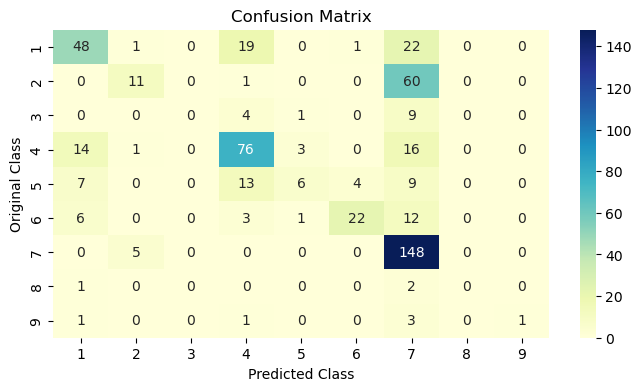

-------------------- Precision matrix (Column Sum=1) --------------------


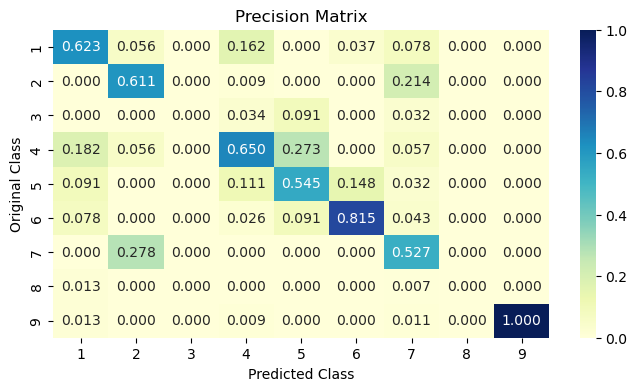

-------------------- Recall matrix (Row sum=1) --------------------


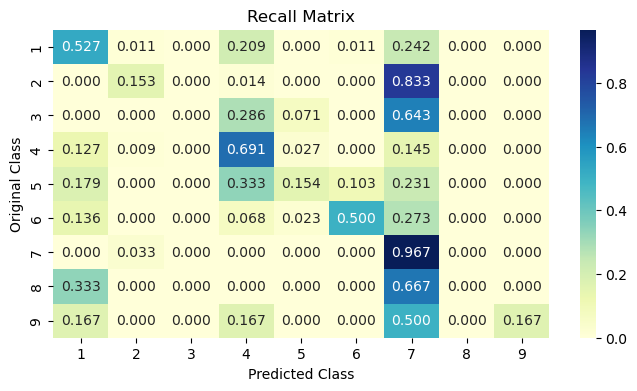

In [184]:
# Fit the MultinomialNB and CalibratedClassifierCV models
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)

sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

# Predict probabilities for cross-validation data
sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)

# to avoid rounding error while multiplying probabilites we use log-probability estimates
print("Log Loss :",log_loss(cv_y, sig_clf_probs))
print("Number of missclassified point :", np.count_nonzero((sig_clf.predict(cv_x_onehotCoding)!= cv_y))/cv_y.shape[0])
plot_confusion_matrix(cv_y, sig_clf.predict(cv_x_onehotCoding.toarray()))

In [185]:
for i in range(10):
    test_point_index = i
    no_feature = 100
    
    # Get predicted class and probabilities
    predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
    print("Predicted Class :", predicted_cls[0])
    print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]), 4))
    print("Actual Class :", test_y[test_point_index])

    print("-" * 50)

Predicted Class : 1
Predicted Class Probabilities: [[0.4233 0.0033 0.0007 0.3433 0.1814 0.0262 0.0205 0.0012 0.    ]]
Actual Class : 4
--------------------------------------------------
Predicted Class : 7
Predicted Class Probabilities: [[3.750e-02 1.870e-02 5.000e-04 8.590e-02 7.400e-03 4.800e-03 8.434e-01
  1.800e-03 0.000e+00]]
Actual Class : 7
--------------------------------------------------
Predicted Class : 7
Predicted Class Probabilities: [[1.490e-02 2.800e-02 5.300e-03 1.820e-02 2.390e-02 1.470e-02 8.922e-01
  2.600e-03 2.000e-04]]
Actual Class : 7
--------------------------------------------------
Predicted Class : 1
Predicted Class Probabilities: [[0.5812 0.1112 0.021  0.0566 0.0467 0.0437 0.1278 0.0064 0.0055]]
Actual Class : 1
--------------------------------------------------
Predicted Class : 7
Predicted Class Probabilities: [[1.290e-02 1.220e-02 9.500e-03 2.400e-02 3.250e-02 1.480e-02 8.911e-01
  2.700e-03 3.000e-04]]
Actual Class : 7
----------------------------------

### 6.2 KNN Classification

#### Hyper parameter tuning

For alpha = 5 Log Loss : 1.077578165040425
For alpha = 11 Log Loss : 1.057760346387645
For alpha = 15 Log Loss : 1.0661668175246226
For alpha = 21 Log Loss : 1.0811488099844622
For alpha = 31 Log Loss : 1.0888234768107967
For alpha = 41 Log Loss : 1.0951826151386441
For alpha = 51 Log Loss : 1.0963499290182541
For alpha = 99 Log Loss : 1.1114885208507916


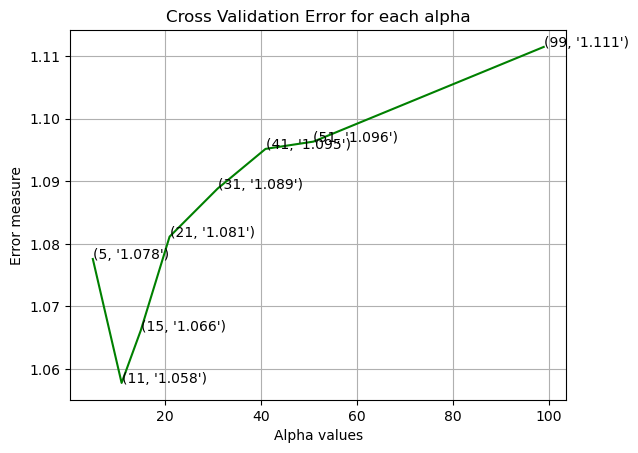

For best alpha = 11 The train log loss is: 0.5996833482397148
For best alpha = 11 The cross-validation log loss is: 1.057760346387645
For best alpha = 11 The test log loss is: 1.0856007322865233


In [186]:
alpha = [5, 11, 15, 21, 31, 41, 51, 99]
cv_log_error_array = []

for i in alpha:
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(train_x_responseCoding, train_y)

    # Calibrate the classifier
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_responseCoding, train_y)

    # Get predicted probabilities
    sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
    
    # Calculate log loss and append to array
    log_loss_value = log_loss(cv_y, sig_clf_probs, labels=clf.classes_)
    cv_log_error_array.append(log_loss_value)
    
    print(f'For alpha = {i} Log Loss : {log_loss_value}')

# Plotting the results
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array, color='g')
for i, txt in enumerate(np.round(cv_log_error_array, 3)):
    ax.annotate((alpha[i], str(txt)), (alpha[i], cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha values")
plt.ylabel("Error measure")
plt.show()

# Find the best alpha
best_alpha_index = np.argmin(cv_log_error_array)
best_alpha = alpha[best_alpha_index]

# Retrain with the best alpha
clf = KNeighborsClassifier(n_neighbors=best_alpha)
clf.fit(train_x_responseCoding, train_y)

# Calibrate the classifier again
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

# Evaluate log loss on training, cross-validation, and test datasets
train_predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For best alpha =', best_alpha, "The train log loss is:", log_loss(y_train, train_predict_y))

cv_predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For best alpha =', best_alpha, "The cross-validation log loss is:", log_loss(y_cv, cv_predict_y))

test_predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For best alpha =', best_alpha, "The test log loss is:", log_loss(y_test, test_predict_y))

#### Testing the model with best hyper paramters

Log loss : 1.057760346387645
Number of mis-classified points : 0.35150375939849626
-------------------- Confusion matrix --------------------


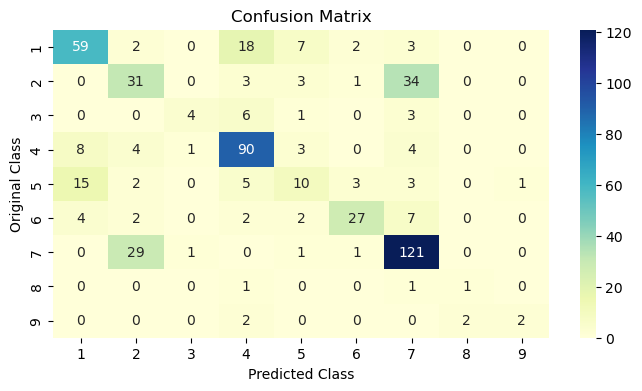

-------------------- Precision matrix (Column Sum=1) --------------------


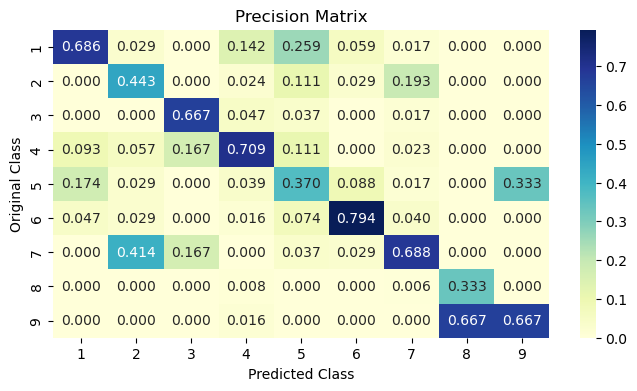

-------------------- Recall matrix (Row sum=1) --------------------


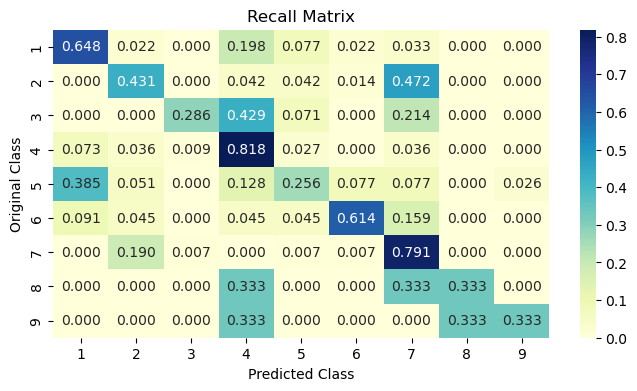

In [187]:
clf = KNeighborsClassifier(n_neighbors=best_alpha)
predict_and_plot_confusion_matrix(train_x_responseCoding, train_y, cv_x_responseCoding, cv_y, clf)

In [188]:
clf = KNeighborsClassifier(n_neighbors=best_alpha)
clf.fit(train_x_responseCoding, train_y)

sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

test_point_index = 1

predicted_cls = sig_clf.predict(test_x_responseCoding[0].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), best_alpha)
print("The ",best_alpha," nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class : 4
Actual Class : 7
The  11  nearest neighbours of the test points belongs to classes [6 2 2 7 7 6 2 2 7 2 7]
Fequency of nearest points : Counter({2: 5, 7: 4, 6: 2})


### 6.3 Logistic Regression

#### With Class balancing

for alpha = 1e-06 , Log Loss : 1.2750596900651772
for alpha = 1e-05 , Log Loss : 1.246454687476453
for alpha = 0.0001 , Log Loss : 1.1160110305993205
for alpha = 0.001 , Log Loss : 1.1739306955837874
for alpha = 0.01 , Log Loss : 1.2413530092690326
for alpha = 0.1 , Log Loss : 1.2813193512560694
for alpha = 1 , Log Loss : 1.484305518464443
for alpha = 10 , Log Loss : 1.5242758606554185
for alpha = 100 , Log Loss : 1.5287165576136375


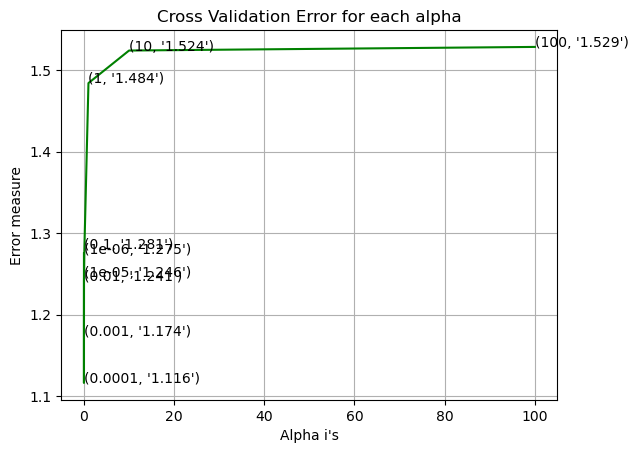

For values of best alpha =  0.0001 The train log loss is: 0.45935598754377377
For values of best alpha =  0.0001 The cross validation log loss is: 1.1160110305993205
For values of best alpha =  0.0001 The test log loss is: 1.0845471974302698


In [189]:
alpha = [10 ** x for x in range(-6, 3)]

cv_log_error_array = []

for i in alpha:
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log_loss', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    log_error = log_loss(cv_y, sig_clf_probs, labels=clf.classes_)
    cv_log_error_array.append(log_error)
    print(f'for alpha = {i} , Log Loss : {log_error}') 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log_loss', random_state=42)
clf.fit(train_x_onehotCoding, train_y)

sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_))

Log loss : 1.1160110305993205
Number of mis-classified points : 0.35150375939849626
-------------------- Confusion matrix --------------------


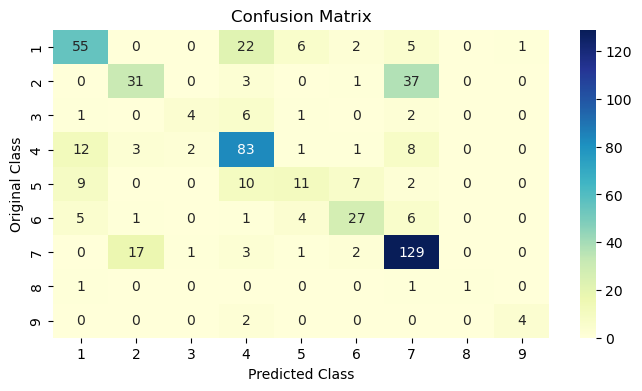

-------------------- Precision matrix (Column Sum=1) --------------------


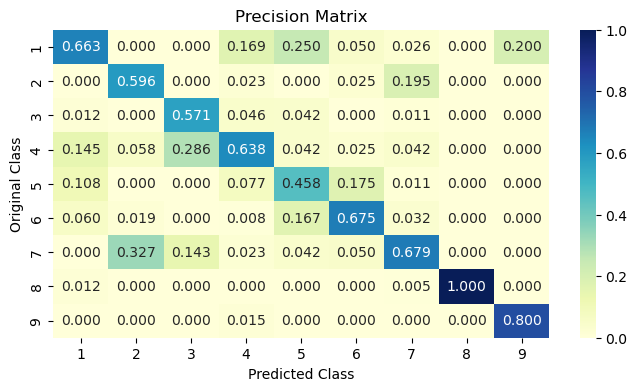

-------------------- Recall matrix (Row sum=1) --------------------


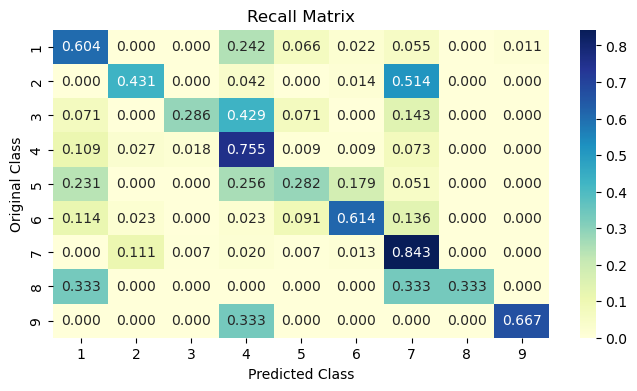

In [191]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log_loss', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

In [193]:
# from tabulate import tabulate
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log_loss', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 1
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
print("-"*50)

Predicted Class : 7
Predicted Class Probabilities: [[0.0079 0.0319 0.0042 0.0163 0.0042 0.001  0.9077 0.0213 0.0054]]
Actual Class : 7
--------------------------------------------------


#### Without Class balancing

for alpha = 1e-06 , Log Loss : 1.259926812256346
for alpha = 1e-05 , Log Loss : 1.1989907038420484
for alpha = 0.0001 , Log Loss : 1.1280236807871908
for alpha = 0.001 , Log Loss : 1.1626873503592274
for alpha = 0.01 , Log Loss : 1.2693003399195377
for alpha = 0.1 , Log Loss : 1.296232567516969
for alpha = 1 , Log Loss : 1.4424829217507766


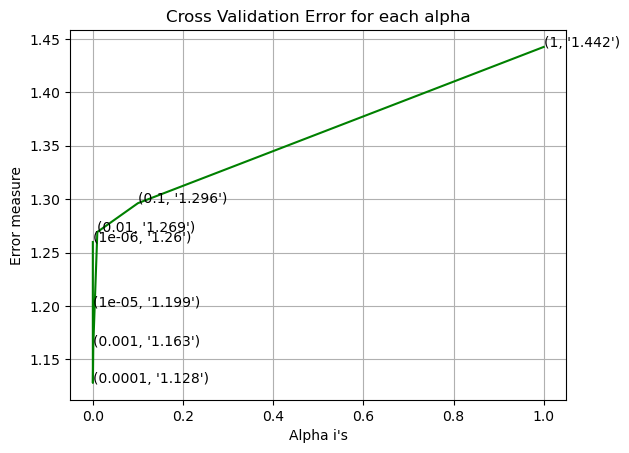

For values of best alpha =  0.0001 The train log loss is: 0.4384069627816008
For values of best alpha =  0.0001 The cross validation log loss is: 1.1280236807871908
For values of best alpha =  0.0001 The test log loss is: 1.099161207312545


In [197]:
alpha = [10 ** x for x in range(-6, 1)]
cv_log_error_array = []

for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log_loss', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    log_error = log_loss(cv_y, sig_clf_probs, labels=clf.classes_)
    cv_log_error_array.append(log_error)
    print(f'for alpha = {i} , Log Loss : {log_error}') 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log_loss', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_))

Log loss : 1.1280236807871908
Number of mis-classified points : 0.34774436090225563
-------------------- Confusion matrix --------------------


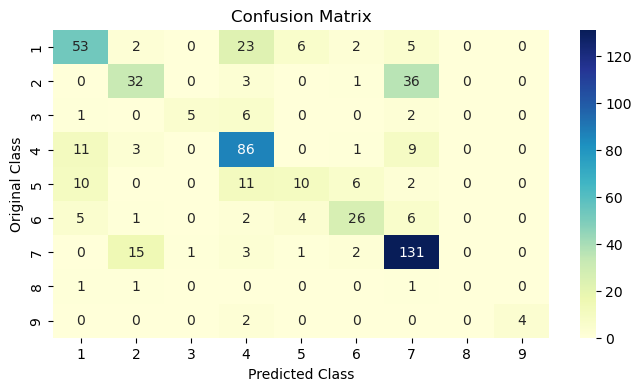

-------------------- Precision matrix (Column Sum=1) --------------------


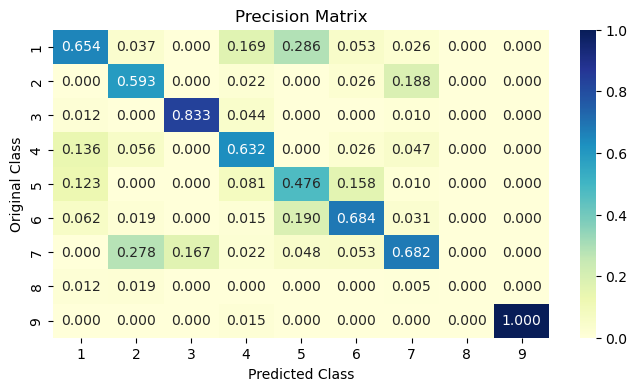

-------------------- Recall matrix (Row sum=1) --------------------


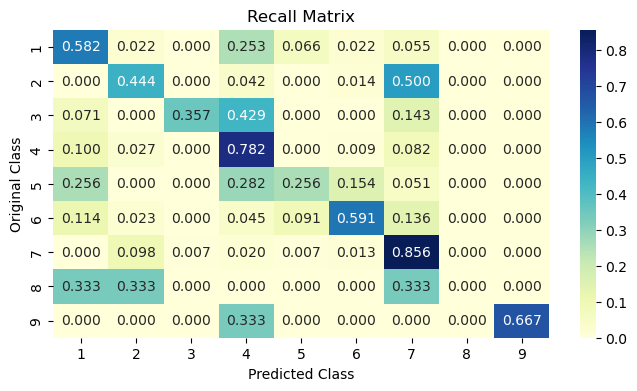

In [198]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log_loss', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

In [202]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log_loss', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 1
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])

Predicted Class : 7
Predicted Class Probabilities: [[0.0218 0.0352 0.0017 0.0626 0.0099 0.0037 0.8515 0.0103 0.0033]]
Actual Class : 7


### 6.4 Linear Support Vector Machines

for C = 1e-05 , Log Loss : 1.2665407523202377
for C = 0.0001 , Log Loss : 1.2008344883417776
for C = 0.001 , Log Loss : 1.149538541100085
for C = 0.01 , Log Loss : 1.214488281251691
for C = 0.1 , Log Loss : 1.3304934101335817
for C = 1 , Log Loss : 1.529595725194758
for C = 10 , Log Loss : 1.5295319088495176
for C = 100 , Log Loss : 1.5295319107225887


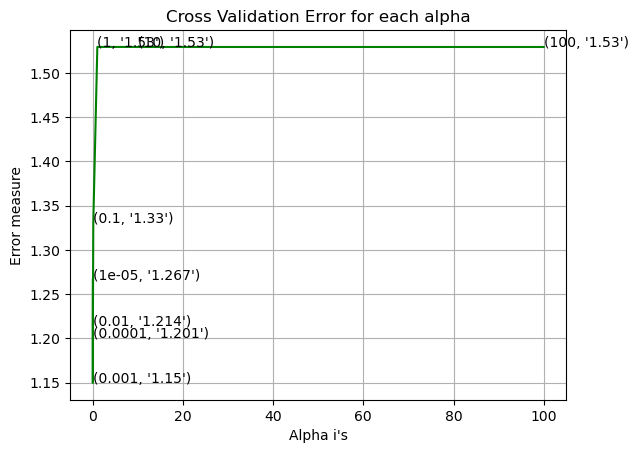

For values of best alpha =  0.001 The train log loss is: 0.5193559267385884
For values of best alpha =  0.001 The cross validation log loss is: 1.149538541100085
For values of best alpha =  0.001 The test log loss is: 1.134145780959386


In [200]:
alpha = [10 ** x for x in range(-5, 3)]
cv_log_error_array = []

for i in alpha:
    # clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
    clf = SGDClassifier( class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    log_error = log_loss(cv_y, sig_clf_probs, labels=clf.classes_)
    cv_log_error_array.append(log_error)
    
    print(f'for C = {i} , Log Loss : {log_error}') 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array, c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)

# clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding, train_y)

sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_))

Log loss : 1.149538541100085
Number of mis-classified points : 0.37218045112781956
-------------------- Confusion matrix --------------------


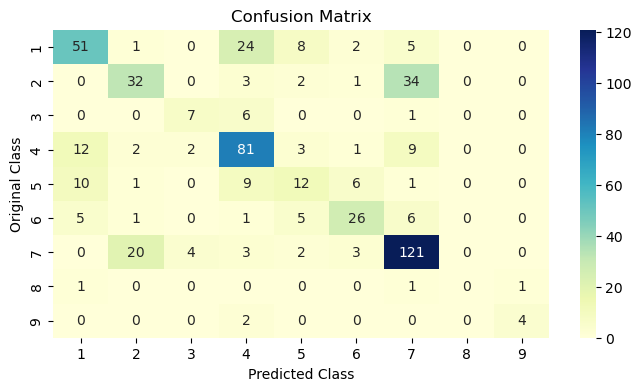

-------------------- Precision matrix (Column Sum=1) --------------------


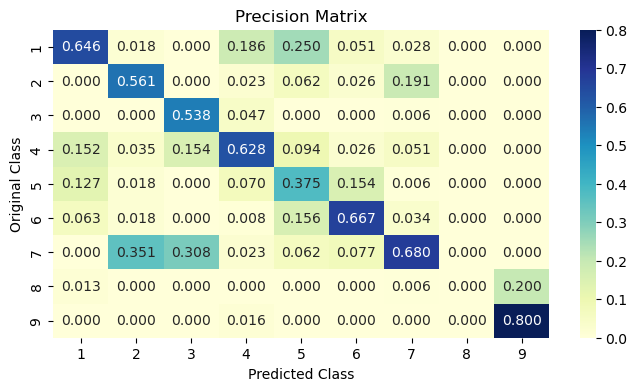

-------------------- Recall matrix (Row sum=1) --------------------


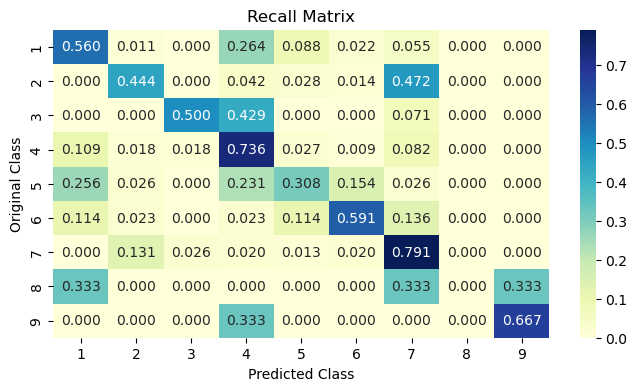

In [201]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42, class_weight='balanced')
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y,cv_x_onehotCoding, cv_y, clf)

In [203]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 1
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])

Predicted Class : 7
Predicted Class Probabilities: [[0.0218 0.0352 0.0017 0.0626 0.0099 0.0037 0.8515 0.0103 0.0033]]
Actual Class : 7


### 6.5 Random Forest Classifier

#### Hyper paramter tuning (With One hot Encoding)

n_estimators = 100, max_depth = 5
Log Loss: 1.2440947327554603
n_estimators = 100, max_depth = 10
Log Loss: 1.1778160774677748
n_estimators = 200, max_depth = 5
Log Loss: 1.2305272256144986
n_estimators = 200, max_depth = 10
Log Loss: 1.1696771258353142
n_estimators = 500, max_depth = 5
Log Loss: 1.2236097145146734
n_estimators = 500, max_depth = 10
Log Loss: 1.1678238807965027
n_estimators = 1000, max_depth = 5
Log Loss: 1.2212034875117255
n_estimators = 1000, max_depth = 10
Log Loss: 1.1645495912677242
n_estimators = 2000, max_depth = 5
Log Loss: 1.2223507345726292
n_estimators = 2000, max_depth = 10
Log Loss: 1.1603687338133022


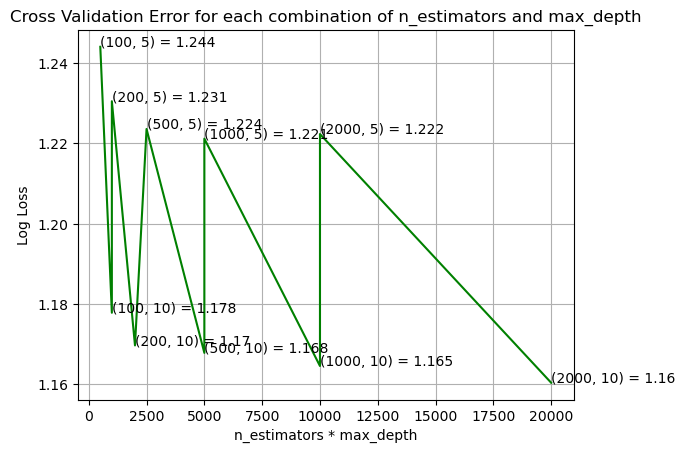

Best n_estimators = 2000, Best max_depth = 10
Train Log Loss: 0.6212935686691805
Cross Validation Log Loss: 1.1603687338133024
Test Log Loss: 1.1618237251715609


In [205]:
# Parameter values for Random Forest
alpha = [100, 200, 500, 1000, 2000]  # Number of estimators (trees)
max_depth = [5, 10]  # Max depth of the trees
cv_log_error_array = []

# Loop over each combination of alpha (n_estimators) and max_depth
for n_estimators in alpha:
    for depth in max_depth:
        print(f"n_estimators = {n_estimators}, max_depth = {depth}")
        
        # Train RandomForestClassifier
        clf = RandomForestClassifier(n_estimators=n_estimators, criterion='gini', max_depth=depth, random_state=42, n_jobs=-1)
        clf.fit(train_x_onehotCoding, train_y)
        
        # Use CalibratedClassifierCV to calibrate the classifier's probability outputs
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_onehotCoding, train_y)
        
        # Predict probabilities on cross-validation set
        sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
        
        # Calculate log loss for cross-validation set
        log_loss_value = log_loss(cv_y, sig_clf_probs, labels=clf.classes_)
        cv_log_error_array.append(log_loss_value)
        
        # Print log loss
        print(f"Log Loss: {log_loss_value}")



fig, ax = plt.subplots()
features = np.dot(np.array(alpha)[:, None], np.array(max_depth)[None]).ravel()
ax.plot(features, cv_log_error_array, color='g')
for i, txt in enumerate(np.round(cv_log_error_array, 3)):
    ax.annotate(f"({alpha[i // 2]}, {max_depth[i % 2]}) = {txt}", (features[i], cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each combination of n_estimators and max_depth")
plt.xlabel("n_estimators * max_depth")
plt.ylabel("Log Loss")
plt.show()

# Select the best parameters based on log loss (lower is better)
best_alpha_index = np.argmin(cv_log_error_array)
best_n_estimators = alpha[best_alpha_index // len(max_depth)]
best_max_depth = max_depth[best_alpha_index % len(max_depth)]

# Train RandomForestClassifier with best parameters
clf = RandomForestClassifier(n_estimators=best_n_estimators, criterion='gini', max_depth=best_max_depth, random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, train_y)

# Calibrate the classifier
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)


# Predict probabilities and calculate log loss for training set
train_probs = sig_clf.predict_proba(train_x_onehotCoding)
train_log_loss = log_loss(train_y, train_probs, labels=clf.classes_)
print(f'Best n_estimators = {best_n_estimators}, Best max_depth = {best_max_depth}')
print(f"Train Log Loss: {train_log_loss}")

# Predict probabilities and calculate log loss for cross-validation set
cv_probs = sig_clf.predict_proba(cv_x_onehotCoding)
cv_log_loss = log_loss(cv_y, cv_probs, labels=clf.classes_)
print(f"Cross Validation Log Loss: {cv_log_loss}")

# Predict probabilities and calculate log loss for test set
test_probs = sig_clf.predict_proba(test_x_onehotCoding)
test_log_loss = log_loss(test_y, test_probs, labels=clf.classes_)
print(f"Test Log Loss: {test_log_loss}")

Log loss : 1.1603687338133024
Number of mis-classified points : 0.39285714285714285
-------------------- Confusion matrix --------------------


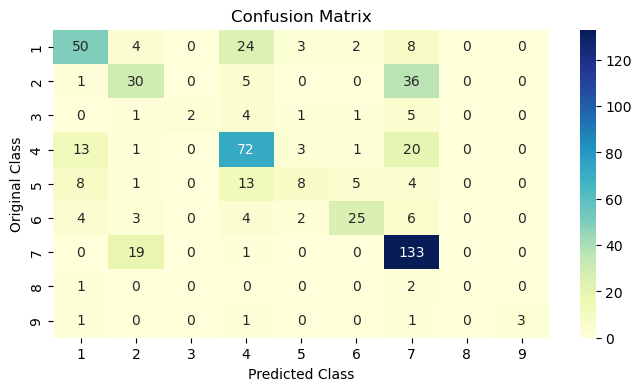

-------------------- Precision matrix (Column Sum=1) --------------------


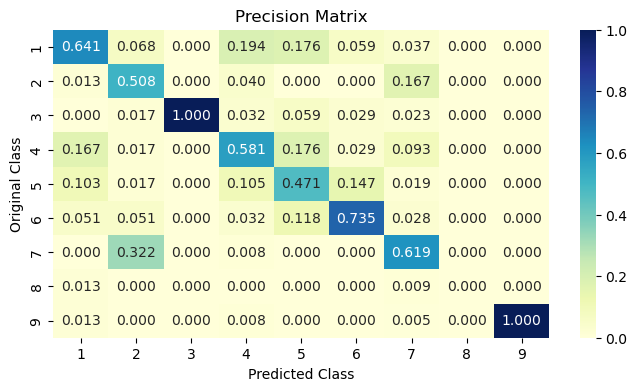

-------------------- Recall matrix (Row sum=1) --------------------


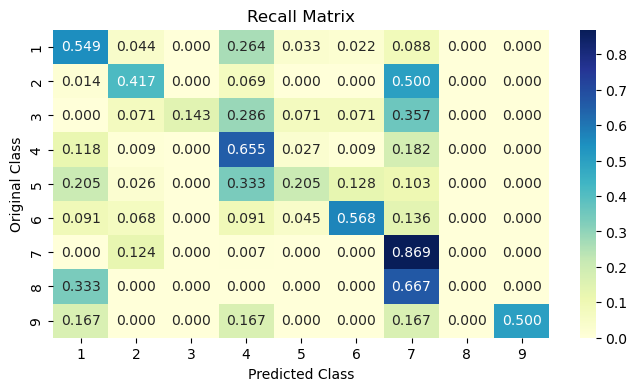

In [206]:
clf = RandomForestClassifier(n_estimators=best_n_estimators, criterion='gini', max_depth=best_max_depth, random_state=42, n_jobs=-1)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

In [207]:
test_point_index = 1
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])

Predicted Class : 7
Predicted Class Probabilities: [[0.1056 0.2188 0.0232 0.1217 0.063  0.0561 0.3953 0.0078 0.0086]]
Actual Class : 7


#### Hyper paramter tuning (With Response Coding)

n_estimators = 10, max_depth = 2
Log Loss: 2.0337267720771766
n_estimators = 10, max_depth = 3
Log Loss: 1.5394439243900206
n_estimators = 10, max_depth = 5
Log Loss: 1.4301798549952616
n_estimators = 10, max_depth = 10
Log Loss: 1.675343158442749
n_estimators = 50, max_depth = 2
Log Loss: 1.6462513967166283
n_estimators = 50, max_depth = 3
Log Loss: 1.3644975954003007
n_estimators = 50, max_depth = 5
Log Loss: 1.365698312071502
n_estimators = 50, max_depth = 10
Log Loss: 1.6493611289490353
n_estimators = 100, max_depth = 2
Log Loss: 1.468651728073894
n_estimators = 100, max_depth = 3
Log Loss: 1.397918657976888
n_estimators = 100, max_depth = 5
Log Loss: 1.3311004851024664
n_estimators = 100, max_depth = 10
Log Loss: 1.6222506507618228
n_estimators = 200, max_depth = 2
Log Loss: 1.5032347940793538
n_estimators = 200, max_depth = 3
Log Loss: 1.4222869619161393
n_estimators = 200, max_depth = 5
Log Loss: 1.3992502673251608
n_estimators = 200, max_depth = 10
Log Loss: 1.6846850152253183


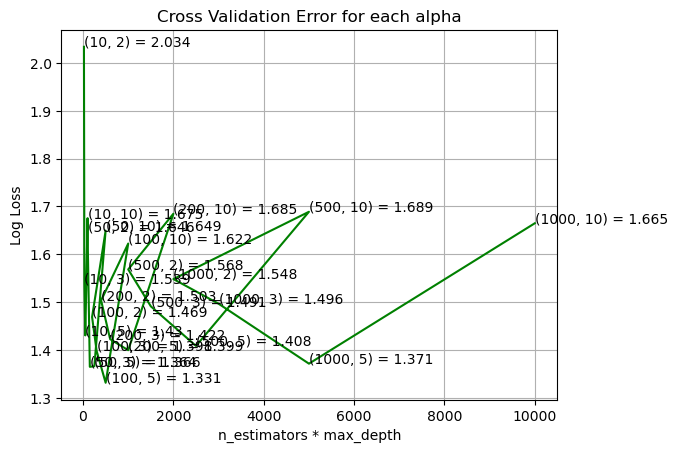

Best n_estimators = 100, Best max_depth = 5
Train Log Loss: 0.06658259335585726
Cross Validation Log Loss: 1.3311004851024664
Test Log Loss: 1.3855516703261892


In [208]:
# Parameters for tuning RandomForest
alpha = [10, 50, 100, 200, 500, 1000]  # n_estimators: number of trees
max_depth = [2, 3, 5, 10]  # max_depth: maximum depth of trees
cv_log_error_array = []

for n_estimators in alpha:
    for depth in max_depth:
        print(f"n_estimators = {n_estimators}, max_depth = {depth}")
        
         # Train the RandomForest model
        clf = RandomForestClassifier(n_estimators=n_estimators, criterion='gini', max_depth=depth, random_state=42, n_jobs=-1)
        clf.fit(train_x_responseCoding, train_y)
        
        # Calibrate the classifier using sigmoid method
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_responseCoding, train_y)
        
        # Predict probabilities on the cross-validation set
        sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
        
        # Calculate log loss for cross-validation
        log_loss_value = log_loss(cv_y, sig_clf_probs, labels=clf.classes_)
        cv_log_error_array.append(log_loss_value)
        
        # Print log loss for this combination of n_estimators and max_depth
        print("Log Loss:", log_loss_value)


fig, ax = plt.subplots()
features = np.dot(np.array(alpha)[:, None], np.array(max_depth)[None]).ravel()
ax.plot(features, cv_log_error_array, color='g')
for i, txt in enumerate(np.round(cv_log_error_array, 3)):
    ax.annotate(f"({alpha[i // 4]}, {max_depth[i % 4]}) = {txt}", (features[i], cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("n_estimators * max_depth")
plt.ylabel("Log Loss")
plt.show()


# Find the best combination of n_estimators and max_depth
best_alpha_idx = np.argmin(cv_log_error_array)
best_n_estimators = alpha[best_alpha_idx // len(max_depth)]
best_max_depth = max_depth[best_alpha_idx % len(max_depth)]

# Train RandomForest with the best parameters
clf = RandomForestClassifier(n_estimators=best_n_estimators, criterion='gini', max_depth=best_max_depth, random_state=42, n_jobs=-1)
clf.fit(train_x_responseCoding, train_y)

# Calibrate the classifier
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

# Calculate log loss on the train set
train_probs = sig_clf.predict_proba(train_x_responseCoding)
train_log_loss = log_loss(train_y, train_probs, labels=clf.classes_)
print(f"Best n_estimators = {best_n_estimators}, Best max_depth = {best_max_depth}")
print(f"Train Log Loss: {train_log_loss}")

# Calculate log loss on the cross-validation set
cv_probs = sig_clf.predict_proba(cv_x_responseCoding)
cv_log_loss = log_loss(cv_y, cv_probs, labels=clf.classes_)
print(f"Cross Validation Log Loss: {cv_log_loss}")

# Calculate log loss on the test set
test_probs = sig_clf.predict_proba(test_x_responseCoding)
test_log_loss = log_loss(test_y, test_probs, labels=clf.classes_)
print(f"Test Log Loss: {test_log_loss}")

Log loss : 1.3311004851024664
Number of mis-classified points : 0.5
-------------------- Confusion matrix --------------------


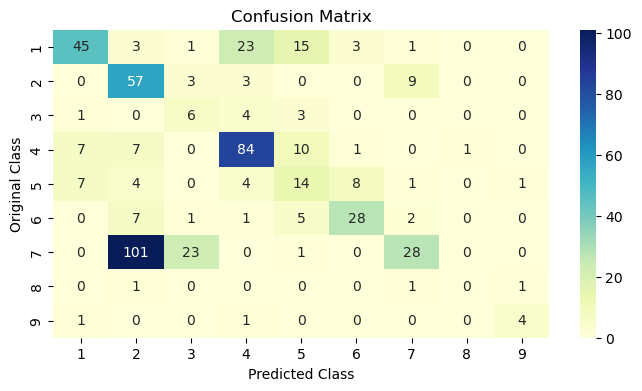

-------------------- Precision matrix (Column Sum=1) --------------------


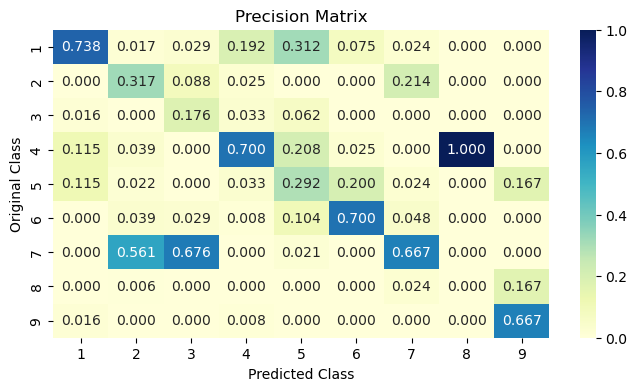

-------------------- Recall matrix (Row sum=1) --------------------


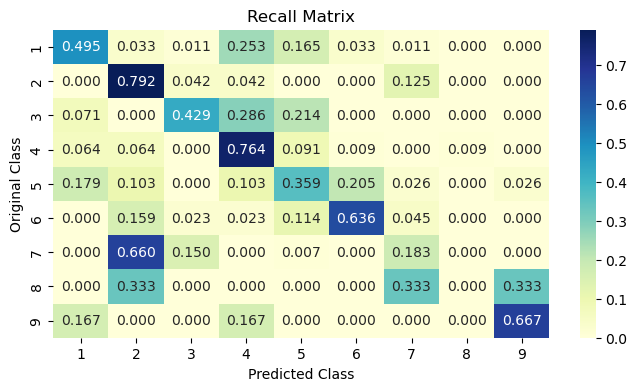

In [210]:
clf = RandomForestClassifier(max_depth=best_max_depth, n_estimators=best_n_estimators, criterion='gini', max_features='sqrt',random_state=42)
predict_and_plot_confusion_matrix(train_x_responseCoding, train_y, cv_x_responseCoding, cv_y, clf)

In [211]:
test_point_index = 1
predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_responseCoding[test_point_index].reshape(1,-1)),4))
print("Actual Class :", test_y[test_point_index])

Predicted Class : 7
Predicted Class Probabilities: [[0.0041 0.299  0.0028 0.008  0.0027 0.0207 0.651  0.0079 0.0037]]
Actual Class : 7


In [212]:
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
for i in indices:
    if i<9:
        print("Gene is important feature")
    elif i<18:
        print("Variation is important feature")
    else:
        print("Text is important feature")

--------------------------------------------------
Variation is important feature
Variation is important feature
Variation is important feature
Variation is important feature
Gene is important feature
Variation is important feature
Variation is important feature
Text is important feature
Text is important feature
Gene is important feature
Text is important feature
Text is important feature
Text is important feature
Gene is important feature
Variation is important feature
Gene is important feature
Gene is important feature
Text is important feature
Gene is important feature
Variation is important feature
Variation is important feature
Text is important feature
Text is important feature
Text is important feature
Gene is important feature
Gene is important feature
Gene is important feature


### 6.6 Stack the models


In [218]:
# Initializing classifiers
clf1 = SGDClassifier(alpha=0.0001, penalty='l2', loss='log_loss', class_weight='balanced', random_state=0)
clf1.fit(train_x_onehotCoding, train_y)
sig_clf1 = CalibratedClassifierCV(clf1, method="sigmoid")

clf2 = SGDClassifier(alpha=0.001, penalty='l2', loss='hinge', class_weight='balanced', random_state=0)
clf2.fit(train_x_onehotCoding, train_y)
sig_clf2 = CalibratedClassifierCV(clf2, method="sigmoid")

clf3 = MultinomialNB(alpha=1000)
clf3.fit(train_x_onehotCoding, train_y)
sig_clf3 = CalibratedClassifierCV(clf3, method="sigmoid")

# Fitting calibrated classifiers
sig_clf1.fit(train_x_onehotCoding, train_y)
print("Logistic Regression: Log Loss: %0.2f" % (log_loss(cv_y, sig_clf1.predict_proba(cv_x_onehotCoding))))
sig_clf2.fit(train_x_onehotCoding, train_y)
print("Support Vector Machines: Log Loss: %0.2f" % (log_loss(cv_y, sig_clf2.predict_proba(cv_x_onehotCoding))))
sig_clf3.fit(train_x_onehotCoding, train_y)
print("Naive Bayes: Log Loss: %0.2f" % (log_loss(cv_y, sig_clf3.predict_proba(cv_x_onehotCoding))))

print("-"*50)

# Optimizing the stacking classifier with different alpha values
alpha = [0.0001, 0.001, 0.01, 0.1, 1, 10]
best_alpha = 999

for i in alpha:
    
    lr = LogisticRegression(C=i, max_iter=500)
    
    sclf = StackingClassifier(estimators=[('sgd1', sig_clf1), ('sgd2', sig_clf2), ('nb', sig_clf3)], 
                              final_estimator=lr)
    
    sclf.fit(train_x_onehotCoding, train_y)
    log_error = log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))
    
    if best_alpha > log_error:
        best_alpha = log_error
    
    print("Stacking Classifier: for the value of alpha: %f Log Loss: %0.3f" % (i, log_error))

Logistic Regression: Log Loss: 1.12
Support Vector Machines: Log Loss: 1.16
Naive Bayes: Log Loss: 1.26
--------------------------------------------------
Stacking Classifier: for the value of alpha: 0.000100 Log Loss: 1.815
Stacking Classifier: for the value of alpha: 0.001000 Log Loss: 1.702
Stacking Classifier: for the value of alpha: 0.010000 Log Loss: 1.303
Stacking Classifier: for the value of alpha: 0.100000 Log Loss: 1.095
Stacking Classifier: for the value of alpha: 1.000000 Log Loss: 1.081
Stacking Classifier: for the value of alpha: 10.000000 Log Loss: 1.103


Log loss (train) on the stacking classifier : 0.39865412084694024
Log loss (CV) on the stacking classifier : 1.0807072276324954
Log loss (test) on the stacking classifier : 1.0565246967294735
Number of missclassified point : 0.3533834586466165
-------------------- Confusion matrix --------------------


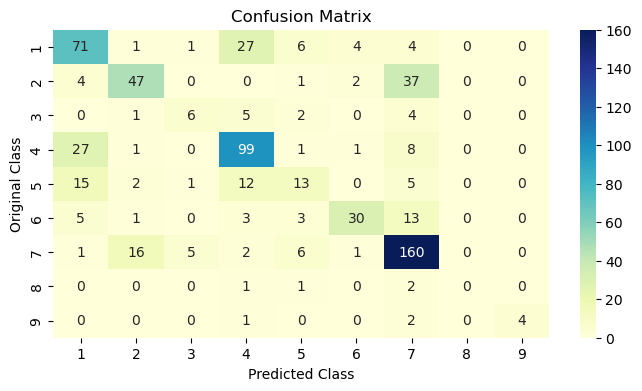

-------------------- Precision matrix (Column Sum=1) --------------------


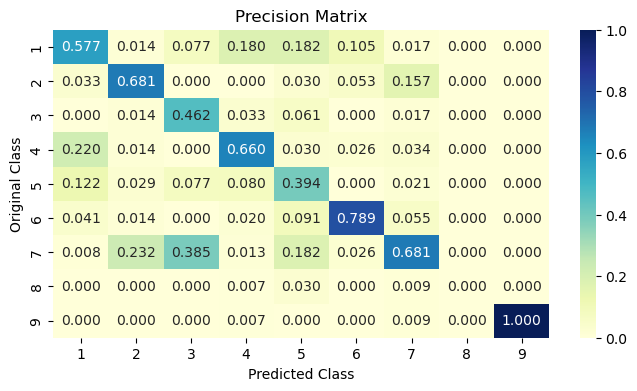

-------------------- Recall matrix (Row sum=1) --------------------


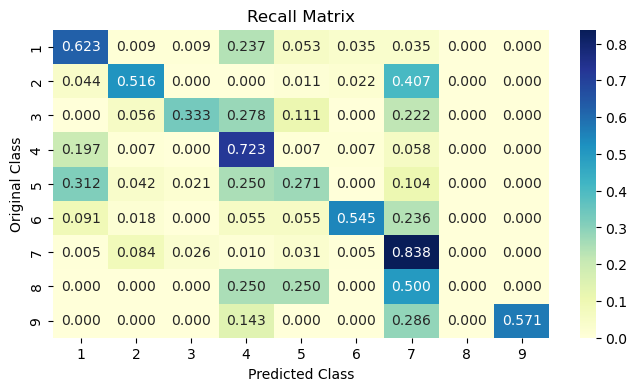

In [219]:
lr = LogisticRegression(C=1)
sclf = StackingClassifier(estimators=[('sgd1', sig_clf1), ('sgd2', sig_clf2), ('nb', sig_clf3)], 
                              final_estimator=lr)
sclf.fit(train_x_onehotCoding, train_y)

log_error = log_loss(train_y, sclf.predict_proba(train_x_onehotCoding))
print("Log loss (train) on the stacking classifier :",log_error)

log_error = log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))
print("Log loss (CV) on the stacking classifier :",log_error)

log_error = log_loss(test_y, sclf.predict_proba(test_x_onehotCoding))
print("Log loss (test) on the stacking classifier :",log_error)

print("Number of missclassified point :", np.count_nonzero((sclf.predict(test_x_onehotCoding)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=sclf.predict(test_x_onehotCoding))

# 7. Table

In [222]:
from prettytable import PrettyTable

x = PrettyTable()
x.field_names =["Models", "Misclassified(%)", "Train", "CV", "Test"]

x.add_row(["Naive Bayes (One hot encoding)", 0.41,0.90,1.25,1.20])
x.add_row(["KNN (Response)",0.35,0.59,1.05,1.05])
x.add_row(["LR (Class balanced) (one hot encoding)",0.35,0.45,1.11,1.08])
x.add_row(["LR (Class unbalanced) (one hot encoding)",0.34,0.43,1.12,1.09])
x.add_row(["Lr SVM (one hot encoding)",0.37,0.51,1.14,1.13])
x.add_row(["Random Forest (one hot coding)",0.39,0.62,1.16,1.16])
x.add_row(["Random Forest (Response coding)",0.50,0.06,1.33,1.38])
x.add_row(["Stacking classifier",0.35,0.39,1.08,1.05])
print(x)

+------------------------------------------+------------------+-------+------+------+
|                  Models                  | Misclassified(%) | Train |  CV  | Test |
+------------------------------------------+------------------+-------+------+------+
|      Naive Bayes (One hot encoding)      |       0.41       |  0.9  | 1.25 | 1.2  |
|              KNN (Response)              |       0.35       |  0.59 | 1.05 | 1.05 |
|  LR (Class balanced) (one hot encoding)  |       0.35       |  0.45 | 1.11 | 1.08 |
| LR (Class unbalanced) (one hot encoding) |       0.34       |  0.43 | 1.12 | 1.09 |
|        Lr SVM (one hot encoding)         |       0.37       |  0.51 | 1.14 | 1.13 |
|      Random Forest (one hot coding)      |       0.39       |  0.62 | 1.16 | 1.16 |
|     Random Forest (Response coding)      |       0.5        |  0.06 | 1.33 | 1.38 |
|           Stacking classifier            |       0.35       |  0.39 | 1.08 | 1.05 |
+------------------------------------------+----------